In [2]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from scipy.stats import uniform, randint, loguniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt
import utils.utils as utils
import shap

### Model training
In this part of the challenge we will try to find the best model with the best performance in the data we did feature engineering, preprocessing, etc

In [5]:
train = pd.read_csv('data/train_data.csv')
test = pd.read_csv('data/test_data.csv')

In [6]:
y_train = train.pop('target')
X_train = train.copy()

y_test = test.pop('target')
X_test = test.copy()

In [7]:
y_train.value_counts()/len(y_train)

0    0.804964
1    0.195036
Name: target, dtype: float64

In [8]:
y_test.value_counts()/len(y_test)

0    0.835677
1    0.164323
Name: target, dtype: float64

###### As we are working with an imbalanced dataset, we will address this issue by utilizing the scale_pos_weight parameter in XGBoost, which aims to alleviate the challenges associated with class imbalance.

###### Define some parameters for the training step

In [306]:
random_state = 1567
scoring = 'roc_auc'
n_splits = 5
n_iter = 600
param_distributions = param_distributions = {
            'max_depth': randint(low=2, high=3),
            'learning_rate': uniform(loc=0.00001, scale=0.1),
            'gamma': uniform(loc=1.0, scale=10.0),
            'min_child_weight': uniform(loc=7.0, scale=20.0),
            'max_delta_step': uniform(loc=0.5, scale=2),
            'subsample': uniform(loc=0.01, scale=0.3),
            'colsample_bytree': uniform(loc=0.01, scale=0.3),
            'colsample_bylevel': uniform(loc=0.5, scale=0.499),
            'reg_alpha': uniform(loc=0.001, scale=10),
            'reg_lambda': uniform(loc=0.001, scale=10),
            'n_estimators': randint(low=20, high=200),
            'scale_pos_weight': uniform(loc=0.5, scale=400)
        }


In [307]:
clf = xgb.XGBClassifier(
        objective="binary:logistic", eval_metric="logloss",
        use_label_encoder=False, random_state=random_state)
# Instantiating randomized search
rsearch = RandomizedSearchCV(
                estimator=clf,
                param_distributions=param_distributions,
                random_state=random_state,
                scoring=scoring,
                cv=n_splits,
                verbose=1,
                n_iter=n_iter
    )
models = rsearch.fit(X_train, y_train, verbose=True)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


In [308]:
# Printing best model results and save best model and params
print('Best score:', models.best_score_)
print('Best hyperparameters:', models.best_params_, end='\n')
model = models.best_estimator_
params = models.best_params_

Best score: 0.5908338655229702
Best hyperparameters: {'colsample_bylevel': 0.891072579464004, 'colsample_bytree': 0.2618754212808408, 'gamma': 4.205867604451735, 'learning_rate': 0.04194018328160591, 'max_delta_step': 1.6022295227833754, 'max_depth': 2, 'min_child_weight': 26.694782003142535, 'n_estimators': 175, 'reg_alpha': 3.0952251557103416, 'reg_lambda': 7.674507829098105, 'scale_pos_weight': 5.1836502784499245, 'subsample': 0.17617033114526318}


In [309]:
joblib.dump(model, 'models/model.joblib.dat')

['models/model_4.joblib.dat']

In [9]:
model = joblib.load('models/model.joblib.dat')

###### Performance metrics

In [7]:

def get_metrics(y_real, y_scores, set_name: str, ts_list: list):
    print('{} Results:\n'.format(set_name))
    roc_auc = metrics.roc_auc_score(y_real, y_scores)
    print('    AUC: {:.4f}\n'.format(roc_auc))

    
    try:
        bin_distribution = pd.DataFrame(pd.cut(y_scores, bins=np.arange(0, 1.1, 0.1)).value_counts(), columns=['COUNT'])
    except:
        bin_distribution = pd.DataFrame(pd.cut(y_scores, bins=np.arange(0, 1.1, 0.1)).value_counts())
        bin_distribution = bin_distribution.rename(columns={'SCORE': 'COUNT'})
    bin_distribution['Class 1'] = pd.cut(y_scores[y_real == True], bins=np.arange(0, 1.1, 0.1)).value_counts()
    bin_distribution['Class 1'] = bin_distribution['Class 1'] / bin_distribution['COUNT']
    bin_distribution['Class 0'] = pd.cut(y_scores[y_real == False], bins=np.arange(0, 1.1, 0.1)).value_counts()
    bin_distribution['Class 0'] = bin_distribution['Class 0'] / bin_distribution['COUNT']
    bin_distribution['PROPORTION'] = bin_distribution['COUNT'] / y_scores.shape[0]
    bin_distribution = bin_distribution.sort_index(ascending=True)
    bin_distribution[['Class 1', 'Class 0']].plot(kind='barh', stacked=True, color=['#fb6376', '#3a7ca5'], title='scores')
    plt.legend(loc='lower right')

    for i, (_, row) in enumerate(bin_distribution.iterrows()):
        plt.text(0.05, i - 0.11, str(int(row.COUNT)), color='white')
    plt.subplots_adjust(left=0.2)
    plt.savefig('img/scores.png'); plt.close()

    precisions, recalls, thresholds = metrics.precision_recall_curve(y_real, y_scores)
    f1_scores = 2 * recalls * precisions / (recalls + precisions + 0.00000000000000001)
    f1_list, precision_list, recall_list = [], [], []
    
    for ts in ts_list:
        print('    For {:.4f} Threshold:'.format(ts), end='\n\n')
        precision, recall, f1_score = precisions[np.argwhere(thresholds >= ts)[0]][0], recalls[np.argwhere(thresholds >= ts)[0]][0], f1_scores[np.argwhere(thresholds >= ts)[0]][0]
        print('        Precision:   {:.4f} | Recall:      {:.4f} | F1 Score:    {:.4f}'.format(precision, recall, f1_score))
        f1_list.append(f1_score); precision_list.append(precision); recall_list.append(recall)

        y_pred = (y_scores >= ts).astype(int)
        cm = metrics.confusion_matrix(y_real, y_pred)
        npv, specificity = cm[0, 0] / (cm[0, 0] + cm[1, 0]), cm[0, 0] / (cm[0, 0] + cm[0, 1])
        h_mean = 2 * npv * specificity / (npv + specificity + 0.00000000000000001)
        print('        NPV:         {:.4f} | Specificity: {:.4f} | H. Mean:     {:.4f}'.format(npv, specificity, h_mean))
        
        print('\n        Confusion Matrix')
        confusion_matrix = pd.DataFrame(cm, columns=['Pred 0', 'Pred 1'], index=['        Real 0', '        Real 1'])
        print(confusion_matrix)
        print('')

    return roc_auc, ts_list, f1_list, precision_list, recall_list

In [10]:
def is_jsonable(x):
    try:
        json.dumps(x)
        return True
    except:
        return False

In [11]:
def performance_metrics(
            X_train, y_train, X_test, y_test,
            model, manual_threshold):
    # Getting predicted scores
    y_scores_test = model.predict_proba(X_test)[:, 1]
    y_scores_train = model.predict_proba(X_train)[:, 1]
    
    # Getting ROC AUC
    auc_test = metrics.roc_auc_score(y_test, y_scores_test)
    auc_train = metrics.roc_auc_score(y_train, y_scores_train)
    print(f'AUC\n{14 * "-"}\nTrain:\t{auc_train:.2%}\nTest:\t{auc_test:.2%}\n{14 * "-"}\n')
    print(f'AUC\n{14 * "-"}\nResult:\t{auc_test:.2%}\n{14 * "-"}\n')

    # Train Results
    threshold = 0.01
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_train, y_scores_train)
    f1_scores = 2 * recalls * precisions / (recalls + precisions + 0.00000000000000001)
    threshold = float(thresholds[np.argmax(f1_scores)])
    get_metrics(
        y_train, y_scores_train, 'Train', [threshold, manual_threshold])

    # Test Results
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, y_scores_test)
    f1_scores = 2 * recalls * precisions / (recalls + precisions + 0.00000000000000001)
    print('Test Precisions & Thresholds where Precision >= 0.7')
    try:
        suggested_thresholds = pd.DataFrame(precisions[np.argwhere(precisions >= 0.7)][0:-1].flatten(), columns=['PRECISION'])
        suggested_thresholds['THRESHOLD'] = thresholds[np.argwhere(precisions[0:-1] >= 0.7)].flatten()
        print(suggested_thresholds.iloc[-50:, :])
    except:
        print('None found!')
    print('')
    roc_auc, ts_list, f1_list, precision_list, recall_list = get_metrics(
        y_test, y_scores_test, 'Test', [threshold, manual_threshold])

    colors = ['#e71d36', '#fdd85d', '#6798c0', '#b0b8b4ff', '#977390']
    # Printing ROC curves
    plt.figure(figsize=(6, 6))
    utils.plot_roc(y_test, y_scores_test, 'Test', colors[1])
    utils.plot_roc(y_train, y_scores_train, 'Train', colors[2])
    utils.format_plot('ROC Curve', 'False Positive Rate', 'True Positive Rate (Recall)')
    plt.savefig('img/roc.png', dpi=500, bbox_inches='tight'); plt.close()

    # Printing PRC curves
    plt.figure(figsize=(6, 6))
    utils.plot_prc(y_test, y_scores_test, 'Test', colors[1])
    utils.plot_prc(y_train, y_scores_train, 'Train', colors[2])
    utils.format_plot('PRC', 'Recall', 'Precision')
    plt.savefig('img/pcr.png', dpi=500, bbox_inches='tight'); plt.close()

    # Printing KS curves
    plt.figure(figsize=(6, 6))
    ks, t_ = utils.plot_ks(y_test, y_scores_test, ['#fb6376', '#3a7ca5'])
    utils.plot_ks_2(y_test, y_scores_test, 'Test', colors[1])
    utils.format_plot('KS', 'Threshold', 'Rate (Cumulative Distribution) / KS value')
    plt.savefig('img/ks.png', dpi=500, bbox_inches='tight'); plt.close()


    # Saving metrics
    metric_scores = {
        'roc_auc': roc_auc,
        'threshold': ts_list[0],
        'f1_score': f1_list[0], 
        'precision': precision_list[0], 
        'recall': recall_list[0],
        'manual_threshold': ts_list[1],
        'mt_f1_score': f1_list[1], 
        'mt_precision': precision_list[1], 
        'mt_recall': recall_list[1],
        'params': {k: v for k, v in model.__dict__.items() if is_jsonable(v) and k[:1]!="_"}
    }

    return metric_scores

In [12]:
performance_metrics(
            X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
            model=model, manual_threshold=0.133)

AUC
--------------
Train:	62.34%
Test:	58.42%
--------------

AUC
--------------
Result:	58.42%
--------------

Train Results:

    AUC: 0.6234

    For 0.9513 Threshold:

        Precision:   0.2337 | Recall:      0.8217 | F1 Score:    0.3639
        NPV:         0.8893 | Specificity: 0.3470 | H. Mean:     0.4992

        Confusion Matrix
                Pred 0  Pred 1
        Real 0    2780    5231
        Real 1     346    1595

    For 0.1330 Threshold:

        Precision:   0.1950 | Recall:      1.0000 | F1 Score:    0.3264
        NPV:         nan | Specificity: 0.0000 | H. Mean:     nan

        Confusion Matrix
                Pred 0  Pred 1
        Real 0       0    8011
        Real 1       0    1941

Test Precisions & Thresholds where Precision >= 0.7
Empty DataFrame
Columns: [PRECISION, THRESHOLD]
Index: []

Test Results:

    AUC: 0.5842



/var/folders/q6/n6rgc74x44dc9p4jhvcb_p0w0000gp/T/ipykernel_2650/1665053573.py:38: RuntimeWarning: invalid value encountered in long_scalars
  npv, specificity = cm[0, 0] / (cm[0, 0] + cm[1, 0]), cm[0, 0] / (cm[0, 0] + cm[0, 1])


    For 0.9513 Threshold:

        Precision:   0.1854 | Recall:      0.7115 | F1 Score:    0.2941
        NPV:         0.8716 | Specificity: 0.3851 | H. Mean:     0.5342

        Confusion Matrix
                Pred 0  Pred 1
        Real 0     801    1279
        Real 1     118     291

    For 0.1330 Threshold:

        Precision:   0.1643 | Recall:      1.0000 | F1 Score:    0.2823
        NPV:         nan | Specificity: 0.0000 | H. Mean:     nan

        Confusion Matrix
                Pred 0  Pred 1
        Real 0       0    2080
        Real 1       0     409



/var/folders/q6/n6rgc74x44dc9p4jhvcb_p0w0000gp/T/ipykernel_2650/1665053573.py:38: RuntimeWarning: invalid value encountered in long_scalars
  npv, specificity = cm[0, 0] / (cm[0, 0] + cm[1, 0]), cm[0, 0] / (cm[0, 0] + cm[0, 1])


{'roc_auc': 0.5841916259168705,
 'threshold': 0.9512694478034973,
 'f1_score': 0.29408792319353205,
 'precision': 0.18535031847133757,
 'recall': 0.7114914425427873,
 'manual_threshold': 0.133,
 'mt_f1_score': 0.28226363008971705,
 'mt_precision': 0.16432302129369225,
 'mt_recall': 1.0,
 'params': {}}

###### Explainability

In [20]:
explainer = shap.TreeExplainer(model)

In [21]:
shap_values = explainer(X_test)

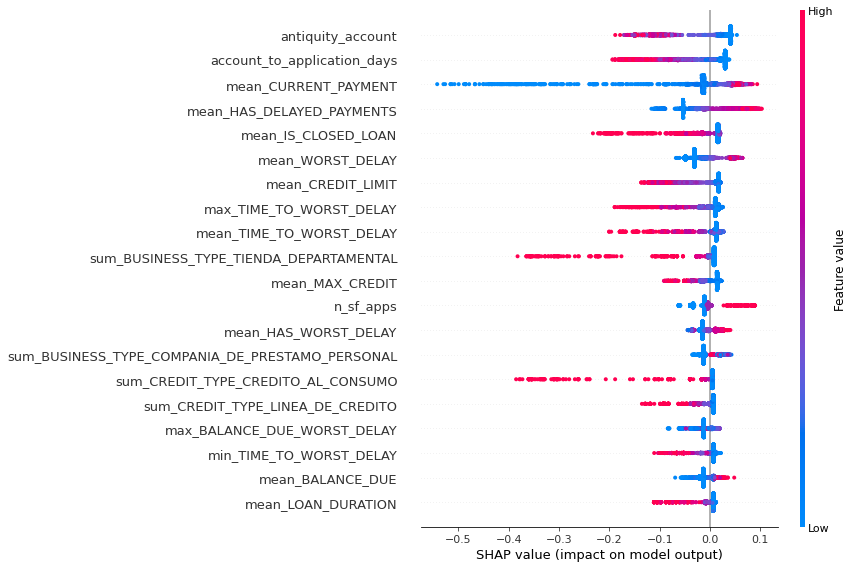

In [39]:
plt.figure(figsize=(16,16))
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig('img/shap_values.png', dpi=300, bbox_inches = 'tight')
plt.show()